In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import zipfile
zip = zipfile.ZipFile("/content/gdrive/My Drive/821469_1405070_bundle_archive.zip", 'r')
zip.extractall("X_ray_dataset")
zip.close()
print("extractzipfile")

extractzipfile


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Declaring the image size and the train, test path of the dataset
# Resizinig all the images to (224,224)
IMAGE_SIZE = [224,224]

train_path = '/content/X_ray_dataset/covid_update/Train'
test_path = '/content/X_ray_dataset/covid_update/Test'


#In this we will be using ResNet-50 Pretrained Moldel


In [ ]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
#Now we dont have to train the existing weights we just have to train our last layer.
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
#By using the Glob function we will be able to know our output classes.
folder = glob('/content/X_ray_dataset/covid_update/*')
folder

['/content/X_ray_dataset/covid_update/Test',
 '/content/X_ray_dataset/covid_update/Train']

In [ ]:
len(folder)

2

In [ ]:
#Now the next we need to Flatten our ResNet model.
#What is Flattening of layer, why is it required?
###We need to convert our 2D features to 1D features. Flatting is required when we have to convert our layer to a fully connected layer.

x = Flatten()(resnet.output)

In [ ]:
#Adding our last laye
prediction = Dense(2, activation='softmax')(x)

In [ ]:
model = Model(inputs = resnet.inputs, outputs = prediction)

In [ ]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
#Compiling our model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#The Data Augmentation 


In [ ]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# flow_from_directory means i am applying all the train_datagen techniques to all the images
# We need to provide the same traget_size as initialized in the IMAGE_SIZE
# If you have more than two classes we should use class_mode = categorical
# But if we have just two classses we can use class_mode = binary

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode = 'categorical')

Found 453 images belonging to 2 classes.


In [ ]:
# Applying the same techniques on the test dataset

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 219 images belonging to 2 classes.


#Training our model

In [ ]:
history = model.fit_generator(train_set, validation_data=test_set, epochs=100, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/100
15/15 [==============================] - 16s 1s/step - loss: 1.6288 - accuracy: 0.6093 - val_loss: 0.4746 - val_accuracy: 0.7717
Epoch 2/100
15/15 [==============================] - 15s 969ms/step - loss: 0.7863 - accuracy: 0.6998 - val_loss: 0.8771 - val_accuracy: 0.6438
Epoch 3/100
15/15 [==============================] - 14s 960ms/step - loss: 0.4619 - accuracy: 0.7859 - val_loss: 0.6388 - val_accuracy: 0.7215
Epoch 4/100
15/15 [==============================] - 15s 968ms/step - loss: 0.3031 - accuracy: 0.8808 - val_loss: 0.4260 - val_accuracy: 0.8082
Epoch 5/100
15/15 [==============================] - 14s 965ms/step - loss: 0.2690 - accuracy: 0.8896 - val_loss: 0.4142 - val_accuracy: 0.8037
Epoch 6/100
15/15 [==============================] - 14s 966ms/step - loss: 0.3030 - accuracy: 0.8764 - val_loss: 0.4027 - val_accuracy: 0.8128
Epoch 7/100
15/15 [==============================] - 15s 988ms/step - loss: 0.3398 - accuracy: 0.8565 - val_loss: 0.8555 - val_accuracy: 0.

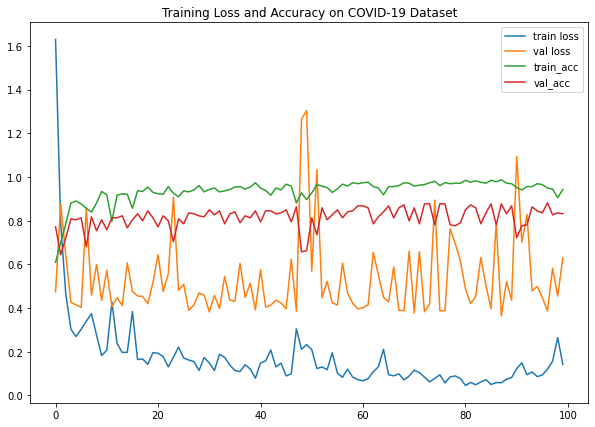

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting the losses and Accuracy on the dataset

plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.legend()
plt.show()
plt.savefig('lossval_loss')

In [ ]:
#Saving the h5 file
from tensorflow.keras.models import load_model

model.save('covid_chest_xray_model.h5')

#Predicting our model

In [ ]:
pred = model.predict(test_set)
pred

array([[1.61816342e-06, 9.99998331e-01],
       [9.98097599e-01, 1.90237444e-03],
       [9.96356905e-01, 3.64304986e-03],
       [5.85200105e-05, 9.99941468e-01],
       [1.65464152e-02, 9.83453572e-01],
       [1.62566418e-03, 9.98374343e-01],
       [1.66132867e-08, 1.00000000e+00],
       [2.45504151e-03, 9.97544944e-01],
       [9.94079674e-05, 9.99900579e-01],
       [9.63761687e-01, 3.62383053e-02],
       [4.43781354e-02, 9.55621839e-01],
       [9.83127117e-01, 1.68728922e-02],
       [3.24707836e-01, 6.75292134e-01],
       [7.08185852e-01, 2.91814148e-01],
       [8.15170542e-10, 1.00000000e+00],
       [6.40582366e-05, 9.99935985e-01],
       [9.46737647e-01, 5.32623380e-02],
       [9.08328116e-01, 9.16719139e-02],
       [1.20669087e-04, 9.99879360e-01],
       [7.90307671e-03, 9.92096901e-01],
       [9.88115668e-01, 1.18843475e-02],
       [8.45909655e-01, 1.54090330e-01],
       [9.60917175e-01, 3.90828215e-02],
       [7.58014200e-03, 9.92419779e-01],
       [4.266718

In [ ]:
import numpy as np

pred = np.argmax(pred, axis=0)
pred

array([59,  6])

In [ ]:
#Loading our model¶

model = load_model('covid_chest_xray_model.h5')

In [ ]:
from tensorflow.keras.preprocessing import image

img = image.load_img('/content/X_ray_dataset/covid_update/Test/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg', target_size=(224,224))

In [ ]:
x = image.img_to_array(img)
x

array([[[ 44.,  42.,  43.],
        [ 53.,  51.,  52.],
        [ 57.,  55.,  56.],
        ...,
        [ 92.,  92.,  92.],
        [ 73.,  73.,  73.],
        [ 54.,  52.,  55.]],

       [[ 54.,  52.,  53.],
        [ 57.,  55.,  56.],
        [ 60.,  58.,  59.],
        ...,
        [ 67.,  65.,  68.],
        [ 71.,  69.,  72.],
        [ 74.,  74.,  76.]],

       [[ 55.,  53.,  56.],
        [ 56.,  56.,  58.],
        [ 59.,  59.,  59.],
        ...,
        [ 92.,  92.,  94.],
        [ 62.,  62.,  64.],
        [ 46.,  44.,  47.]],

       ...,

       [[ 67.,  67.,  69.],
        [ 73.,  73.,  75.],
        [ 70.,  70.,  72.],
        ...,
        [ 67.,  67.,  69.],
        [ 89.,  89.,  91.],
        [ 89.,  89.,  91.]],

       [[ 80.,  80.,  82.],
        [ 74.,  74.,  76.],
        [ 70.,  70.,  72.],
        ...,
        [ 72.,  72.,  74.],
        [ 87.,  87.,  89.],
        [ 93.,  93.,  95.]],

       [[ 78.,  78.,  78.],
        [ 61.,  61.,  63.],
        [ 68.,  

In [ ]:
x.shape

(224, 224, 3)

In [ ]:
x = x/255

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [ ]:
model.predict(img_data)

array([[1.0000000e+00, 4.9063453e-32]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

In [ ]:
if(a==1):
    print("The person does not have COVID-19")
else:
    print("The person has COVID-19")


The person has COVID-19
